In [1]:
import sys
sys.path.append('../')
import numpy as np
import copy
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie_perception import pcd
from magpie_control import realsense_wrapper as real
import cv2
# from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
devices = real.poll_devices()
print(devices)
wrist = real.RealSense(fps=15, w=640, h=480, device_name="D405")
wrist.initConnection(device_serial=devices['D405'])
wkspc = real.RealSense(zMax=5, fps=6, w=640, h=480, device_name="D435")
wkspc.initConnection(device_serial=devices['D435'])

{'D435': '832412070344', 'D405': '126122270157'}
There are 2 available devices!
There are 2 available devices!


In [3]:
pcd_wrist, rgbd_wrist = wrist.getPCD()
pcd_wkspc, rgbd_wkspc = wkspc.getPCD()

img_wrist = np.array(rgbd_wrist.color)
img_wkspc = np.array(rgbd_wkspc.color)

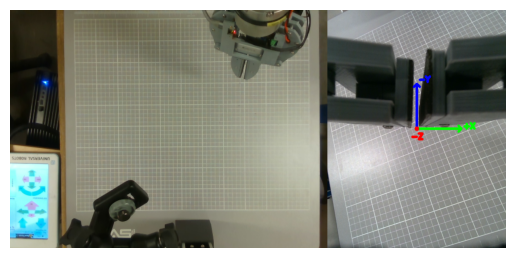

In [7]:
def label_wrist_image(wrist_img):
    '''
    labels wrist image with overlaid x,y,z axes in line with F/T sensor
    '''
    h, w, c = wrist_img.shape

    x_color = (0, 255, 0) # green
    y_color = (0, 0, 255) # blue
    z_color = (255, 0, 0) # red

    # Define axis line lengths (adjust as needed)
    axis_length = min(w, h) // 4

    # Calculate starting point for axes (center of the image)
    center_x, center_y = w // 2, h // 2

    # Draw X-axis
    cv2.arrowedLine(wrist_img, (center_x, center_y), (center_x + axis_length, center_y), x_color, 6)
    cv2.putText(wrist_img, "+X", (center_x + axis_length + 5, center_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, x_color, 5)

    # Draw Y-axis
    cv2.arrowedLine(wrist_img, (center_x, center_y), (center_x, center_y - axis_length), y_color, 6)
    cv2.putText(wrist_img, "-Y", (center_x + 5, center_y - axis_length - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, y_color, 5)

    # Draw Z-axis (pointing towards the viewer, represented as a circle)
    cv2.circle(wrist_img, (center_x, center_y), 6, z_color, -1)  # Filled circle
    cv2.putText(wrist_img, "-Z", (center_x - 15, center_y + 28), cv2.FONT_HERSHEY_SIMPLEX, 0.7, z_color, 5)

    return wrist_img

img_wrist_rotated = cv2.rotate(img_wrist, cv2.ROTATE_90_COUNTERCLOCKWISE)
wrist_img_labeled = label_wrist_image(img_wrist_rotated.copy()) # Use .copy() to avoid modifying the original
# img_wkspc_resized = cv2.resize(img_wkspc, (img_wrist_rotated.shape[1], img_wrist_rotated.shape[0]))
import imutils
img_wkspc_resized = imutils.resize(img_wkspc, height=img_wrist_rotated.shape[0])
final_img = np.hstack((img_wkspc_resized, wrist_img_labeled))

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.imshow(final_img)

In [19]:
initial_prompt = '''
I am providing an image of the robot gripper grasping or about to grasp an {obj}.
On the left is a third-person view of the workspace with the robot gripper and the {obj}.
On the right is a first-person view from the robot gripper wrist.
I have labeled the axes of motion and force sensing for the wrist as such:
+X (green arrow, to the right along the x-axis of the wrist image)
+Y (blue arrow, up the y-axis of the wrist image)
+Z (red dot, ceneted and into the wrist image)

Desired motion description: {task}
Please tell me how the gripper should move, in a few ways.
For each response, provide your answer in the form of 3-element vector corresponding to the X, Y, Z axes.
1. Coarse motion (positive, negative, or nothing)
2. Fine motion (best estimate in meters)
3. Coarse forces (positive, negative, or nothing)
4. Fine forces (best estimate in Newtons)

Before providing your answer, please take a moment to study the image and consider the task.
Consider the mass, friction, stiffness and other such properties of the object and the workspace.
Consider the particular dynamics and forces at play in performing the described task.

Here is a more in-depth explanation of the requested responses:
1. Coarsely, if it should be negative, positive, or no motion, using the values -1, 1, or 0.
For example, if the gripper should move 5cm to the right, you could say [1, 0, 0].

2. Then, using the desired motion description, try to provide a more detailed and numerical answer.
If a distance is specified, try to resolve along the estimated axes of motion.
Or if a non-explicit goal, visual or otherwise, is specified, leverage physical, spatial, semantic, visual, or other cues to provide a more specific answer.
Use units of meters for this array.

3. Coarsely, if it should be negative, positive, or no force, using the values -1, 1, or 0. Account for the environmental forces experienced in a task like {task}

4. Then, using the desired motion description, try to provide a more detailed and numerical answer.
If a force is specified, try to resolve along the estimated axes of force.
Again, leverage physical, spatial, semantic, visual, or other kinds reasoning about the internal and environmental forces experienced to best determine the forces.
'''

In [2]:
def openai_encode_image(image):
    import base64
    import io
    buffer = io.BytesIO()
    img = image.save(buffer, format="JPEG") # image is PIL image
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def create_image_message(text, image, model_type="gemini"):
    '''
    @param text (str): text to be sent to the model
    @param image (PIL.Image): image to be sent to the model
    '''
    message = None
    if model_type == "gemini":
        message = [text, image]
    elif model_type == "openai":
        message = {
            "role": "user",
            "content": [
                {"type": "text", "text": text},
                {
                    "type": "image_url",
                    "data": f"data:image/jpeg;base64,{openai_encode_image(image)}",
                }
            ]
        }
    return message

In [3]:
def send_message(client, model, messages, model_type="gemini"):
    '''
    Sends a list of messages to the specified client and model.

    @param client: The initialized OpenAI or Gemini client.
    @param model (str): The model ID to use.
    @param messages (list): A list of message dictionaries (for OpenAI) or content parts (for Gemini).
    @param model_type (str): Either "openai" or "gemini".
    @return: The response from the model.
    '''
    print(model)
    if model_type == "openai":
        response = client.chat.completions.create(
            model=model,
            messages=messages,
        )
        return response.choices[0].message.content
    elif model_type == "gemini":
        response = client.generate_content(messages)
        return response.prompt_feedback.content_filter_results if response.prompt_feedback else response.parts[0].text
    else:
        raise ValueError(f"Unsupported model type: {model_type}")


In [4]:
# with help from: https://github.com/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb
import os
from PIL import Image
from google import genai
import openai
from dotenv import load_dotenv
import instructor

load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
GEMINI_MODEL_ID = "gemini-2.0-flash" # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true}
# OPENAI_MODEL_ID = "gpt-4o-mini"
OPENAI_MODEL_ID = "gpt-4o"

gemini_client = genai.Client(api_key=GEMINI_API_KEY)
openai_client = openai.OpenAI(api_key=OPENAI_API_KEY)

In [20]:
model_type = "gemini"
# model_type = "openai"
client, model = None, None
if model_type == "openai":
    client = openai_client
    model = OPENAI_MODEL_ID
elif model_type == "gemini":
    client = gemini_client
    model = GEMINI_MODEL_ID
img = Image.open('axes.png').convert("RGB")

obj = "small servo motor"
prompt_config = {
"obj": "small servo motor",
"task": f"move the {obj} 5cm toward the black post"
}

image_response = client.models.generate_content(
    model=model,
    contents=[initial_prompt, img],
)

# response = client.responses.create(
#     model="gpt-4o",
#     input=[{
#         "role": "user",
#         "content": [
#             {"type": "input_text", "text": f"{initial_prompt}"},
#             {
#                 "type": "input_image",
#                 "image_url": f"data:image/jpeg;base64,{openai_encode_image(img)}",
#             },
#         ],
#     }],
# )

# message_history = []
# initial_message = create_image_message(initial_prompt, img, model_type)
# message_history.append(initial_message)

# print(model_type)
# print(f"Sending initial message to {model_type}...")
# response = send_message(client, model, [initial_message] if model_type == "gemini" else message_history, model_type)
# print(f"{model_type} Response:\n{response}\n")

# # Example of a follow-up text-only message
# followup_prompt = "Now move it 2cm to the left."
# followup_message = {"role": "user", "content": followup_prompt} if model_type == "openai" else followup_prompt
# message_history.append(followup_message)

# print(f"Sending follow-up message to {model_type}...")
# followup_response = send_message(client, model, message_history, model_type)
# print(f"{model_type} Follow-up Response:\n{followup_response}")


In [15]:
print(response.output_text)


Sure, here's how the robot gripper should move to achieve the task of moving the small servo motor 5cm forward on the table:

1. **Coarse Motion:**
   - Assuming forward refers to the right along the X-axis in the wrist image:
   - `[1, 0, 0]` (Move in the +X direction)

2. **Fine Motion:**
   - Approximate movement in meters:
   - `[0.05, 0, 0]` (5cm = 0.05 meters forward along the X-axis)

3. **Coarse Forces:**
   - The force exerted horizontally to overcome static friction:
   - `[1, 0, 0]` (Apply force in the +X direction)

4. **Fine Forces:**
   - Assuming a small force to move the servo motor:
   - `[2, 0, 0]` (Approximate as 2 Newtons in the +X direction, depending on surface friction)

These vectors indicate the motion and forces required to achieve the desired task effectively. Adjustments may be needed based on real-world conditions such as surface texture and object weight.


In [21]:
print(image_response.text)

Okay, I understand the setup and the requested format. Here's the analysis for the desired motion:

**Desired motion description:** Grasp the {obj}

**Analysis:**

1.  **Coarse Motion:**
    *   X: 0 (No significant motion along the X-axis is required for grasping. The gripper is aligned on that axis)
    *   Y: -1 (The gripper needs to move down towards the object.)
    *   Z: 0 (No significant motion along the Z-axis is required for grasping. The gripper is aligned on that axis)

2.  **Fine Motion:**
    *   X: 0.00 (No significant motion)
    *   Y: -0.05 (Estimate the distance to move down based on the visible gap between the gripper and the object. An estimated 5cm should be enough)
    *   Z: 0.00 (No significant motion)

3.  **Coarse Forces:**
    *   X: 0 (No significant forces along the X-axis are expected initially)
    *   Y: 1 (A positive force (upwards) will be necessary to counteract gravity once the object is grasped)
    *   Z: 0 (No significant forces along the Z-axis 